In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mticker

In [2]:
# Function to clean the folder by removing files
def clean_folder(folder_path):
    # List all files in the folder
    files = os.listdir(folder_path)
    
    if not files:
        print("The folder is already empty.")
        return

    # Loop through all files and delete those that are not needed
    for file in files:
        try:
            file_path = os.path.join(folder_path, file)
            
            # Delete files that are not needed (for example, all .parquet files)
            if file.endswith('.parquet'):
                os.remove(file_path)
                print(f"Deleted file: {file}")
        
        except Exception as e:
            print(f"Failed to delete {file}: {e}")

# Export Pivot Data
def export_pivot_data(dataset, date_pos, data_position, exportFileName):
    
    # Select the columns by position
    df = dataset.iloc[:, [date_pos, data_position]].copy()
    
    # Rename the columns for easier access
    df.columns = ['Date', 'Data']
    
    # Convert 'Date' column to datetime format
    df['Date'] = pd.to_datetime(df['Date'])

    # Extract week number, month, and year
    df['Week_Num'] = df['Date'].dt.isocalendar().week
    df['Month'] = df['Date'].dt.month
    df['Year'] = df['Date'].dt.year
    
    # df = df.sort_values(by='Date', ascending=False).reset_index(drop=True)
    
    # Pivot the DataFrame to have Week_Num as rows, Year as columns, and Data as values
    pivoted_df = df.pivot_table(index='Week_Num', columns='Year', values='Data')
    
    # Sort the columns to have years starting from the newest
    pivoted_df = pivoted_df.sort_index(axis=1, ascending=False)
    
    # Define the export path
    export_folder = "../data/petroleum/processed/"
    export_file = export_folder + f"{exportFileName}.parquet"
    
    # Export the pivoted DataFrame to Parquet format
    pivoted_df.to_parquet(export_file)

    print("Success processed: " + dataset.columns[data_position])

# Get Summary Data
def calculate_summary(df):
    # Find the last non-NaN value
    last_non_nan_row = df.iloc[:, 0].dropna().index[-1]

    # Get the necessary values
    last_value = df.iloc[last_non_nan_row-1, 0]
    previous_week_value = df.iloc[last_non_nan_row-2, 0]
    previous_month_value = df.iloc[last_non_nan_row-5, 0]
    previous_year_value = df.iloc[last_non_nan_row-1, 1]

    # Calculate percentage changes
    wow_percentage = ((last_value - previous_week_value) / previous_week_value) * 100
    wow_delta = (last_value - previous_week_value)
    mom_percentage = ((last_value - previous_month_value) / previous_month_value) * 100
    yoy_percentage = ((last_value - previous_year_value) / previous_year_value) * 100

    # Create a DataFrame with the calculated values
    summary_df = pd.DataFrame({
        'Last Value': [last_value],
        'WoW Delta': [wow_delta],
        'WoW (%)': [wow_percentage],
        'MoM (%)': [mom_percentage],
        'YoY (%)': [yoy_percentage]
    })

    # Round the values to 3 decimal places
    summary_df = summary_df.round(2)

    return summary_df

def calculate_5_year_metrics(df):
    """
    This function calculates the 5-year maximum, minimum, and average for each row
    excluding the first column in the provided DataFrame.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame with at least 6 columns.
    
    Returns:
    pd.DataFrame: The DataFrame with 5YrMax, 5YrMin, and 5YrAvg columns added.
    """
    
    # Select the columns from the second to the sixth (excluding the first column)
    df = df.iloc[:,0:6]
    fiveYearsRange = df.iloc[:, 1:6]
    
    # Calculate the 5-year max, min, and average for each row
    df["5YrMax"] = fiveYearsRange.max(axis=1)
    df["5YrMin"] = fiveYearsRange.min(axis=1)
    df["5YrAvg"] = fiveYearsRange.mean(axis=1)
    
    return df

def plot_seasonal_trends(pivot_dataset, chart_name, source_text=""):
    # Remove Week 1 and Week 53
    plot_data = pivot_dataset[(pivot_dataset.index != 1) & (pivot_dataset.index != 53)]

    # Ensure plot_data is sorted by index (Week)
    plot_data = plot_data.sort_index()

    # Create a numerical range for the x-axis based on the length of the DataFrame
    x_values = np.arange(len(plot_data))

    # Plotting
    plt.figure(figsize=(12, 6))

    # Plot the 5-Year Max/Min range as a shaded area
    plt.fill_between(x_values, plot_data['5YrMax'], plot_data['5YrMin'], color='lightgray', label='5-Year Range')

    # Colors
    fiveYear_avgColor = "black"
    fiveYear_2023Color = "#FFA500"
    fiveYear_2024Color = "#003366"

    # Plot the 5-Year Average
    plt.plot(plot_data.index, plot_data['5YrAvg'], color=fiveYear_avgColor, linestyle='--', label='5-Year Average', linewidth=1)

    # Plot the 2023 values
    plt.plot(plot_data.index, plot_data[2023], color=fiveYear_2023Color, label='2023', linewidth=1.5, alpha=0.7)

    # Plot the 2024 values
    plt.plot(plot_data.index, plot_data[2024], color=fiveYear_2024Color, marker='o', label='2024', linewidth=2)

    # Formatting the chart
    # plt.title(f'Seasonal Trends of {chart_name}', fontsize=16)
    plt.xlabel('Week', fontsize=14)
    plt.ylabel("Thousand Barrels per Day", fontsize=14)

    # Improve the y-axis to show values in the format '10.000', '20.000', etc.
    def thousands(x, pos):
        """Format the y-axis values with a dot as the thousand separator."""
        return f'{int(x / 1000):,}'.replace(',', '.')  # Format as '10.000', '20.000', etc.

    # Set the y-axis formatter
    plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(thousands))

    plt.legend()
    plt.grid()
    plt.tight_layout()

    # # Add source text at the bottom right of the plot
    # plt.text(0.95, -0.2, source_text, transform=plt.gca().transAxes, fontsize=10, ha='right', va='bottom')
    
    # Save the plot as a PNG file in the specified export path
    export_path = "../report/figures/"
    export_file_name = chart_name.replace(" ", "_") + ".png"
    export_file_path = os.path.join(export_path, export_file_name)
    plt.savefig(export_file_path, bbox_inches='tight')

    # Show the plot
    plt.show()
    

In [3]:
# Raw Datasets
raw_path = "../data/petroleum/raw/"

# List all files in the folder
file_names = os.listdir(raw_path)
import_path_file = os.path.join(raw_path, file_names[0])

# Define the folder path
processed_path = "../data/petroleum/processed/"

clean_folder(processed_path)

Deleted file: 1. total_us_oil_reserves.parquet
Deleted file: 2. commercial_us_oil_reserves.parquet
Deleted file: 3. spr_us_oil_reserves.parquet


In [4]:
# Importing Data
all_dataset = pd.read_excel(import_path_file, sheet_name = "Data 1", skiprows= 2)

In [5]:
export_pivot_data(all_dataset, 0, 3, "1. total_us_oil_reserves")
export_pivot_data(all_dataset, 0, 4, "2. commercial_us_oil_reserves")
export_pivot_data(all_dataset, 0, 7, "3. spr_us_oil_reserves")

Success processed: Weekly U.S. Ending Stocks of Crude Oil  (Thousand Barrels)
Success processed: Weekly U.S. Ending Stocks excluding SPR of Crude Oil  (Thousand Barrels)
Success processed: Weekly U.S. Ending Stocks of Crude Oil in SPR  (Thousand Barrels)


In [6]:
# Prepare General Table

# List all files in the folder
processed_path = "../data/petroleum/processed/"
file_names = os.listdir(processed_path)

# Initialize an empty list to collect summary DataFrames
summary_list = []

# Loop through all files and check for .parquet extension
for file_name in file_names:
    if file_name.endswith('.parquet'):
        # Full file path
        file_path = os.path.join(processed_path, file_name)
        
        # Import the Parquet file
        df = pd.read_parquet(file_path)
        
        # Calculate the summary using the function (assuming calculate_summary is defined)
        summary_df = calculate_summary(df)
        
        # Optionally, add a column to identify the source file
        summary_df['File Name'] = file_name
        
        # Append the summary DataFrame to the list
        summary_list.append(summary_df)

# Concatenate all summary DataFrames into a single DataFrame
final_summary_df = pd.concat(summary_list, ignore_index=True)

# List of names to be added as the first column (make sure the length matches the DataFrame rows)
new_column_names = ['Crude Oil (Including SPR)', 'Commercial Crude Oil (Excl. Lease Stock)', 'SPR']

# Ensure new_column_names list is of the same length as the number of rows
if len(new_column_names) != len(final_summary_df):
    # If the lengths do not match, repeat the list (or customize as needed)
    new_column_names = (new_column_names * (len(final_summary_df) // len(new_column_names))) + new_column_names[:len(final_summary_df) % len(new_column_names)]

# Add the new column with names
final_summary_df['Weekly Stocks'] = new_column_names

# Reorder the columns so that 'Weekly Stocks' is the first column
final_summary_df = final_summary_df[['Weekly Stocks'] + [col for col in final_summary_df.columns if col != 'Weekly Stocks']]

# Define the folder path where you want to save the CSV file
export_table = "../report/tables/"

# Remove the last column
final_summary_df_no_last_column = final_summary_df.iloc[:, :-1]

# Define the export file name (for example, 'final_summary.csv')
export_file = os.path.join(export_table, "oilTable_summary.csv")

# Export the DataFrame to CSV without the last column
final_summary_df_no_last_column.to_csv(export_file, index=False)

print(f"Data exported successfully to {export_file}")

Data exported successfully to ../report/tables/oilTable_summary.csv


/var/folders/ym/3qhchx8d19q8jp5fvb95q9vw0000gn/T/ipykernel_3112/1278560714.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["5YrMax"] = fiveYearsRange.max(axis=1)
/var/folders/ym/3qhchx8d19q8jp5fvb95q9vw0000gn/T/ipykernel_3112/1278560714.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["5YrMin"] = fiveYearsRange.min(axis=1)
/var/folders/ym/3qhchx8d19q8jp5fvb95q9vw0000gn/T/ipykernel_3112/1278560714.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

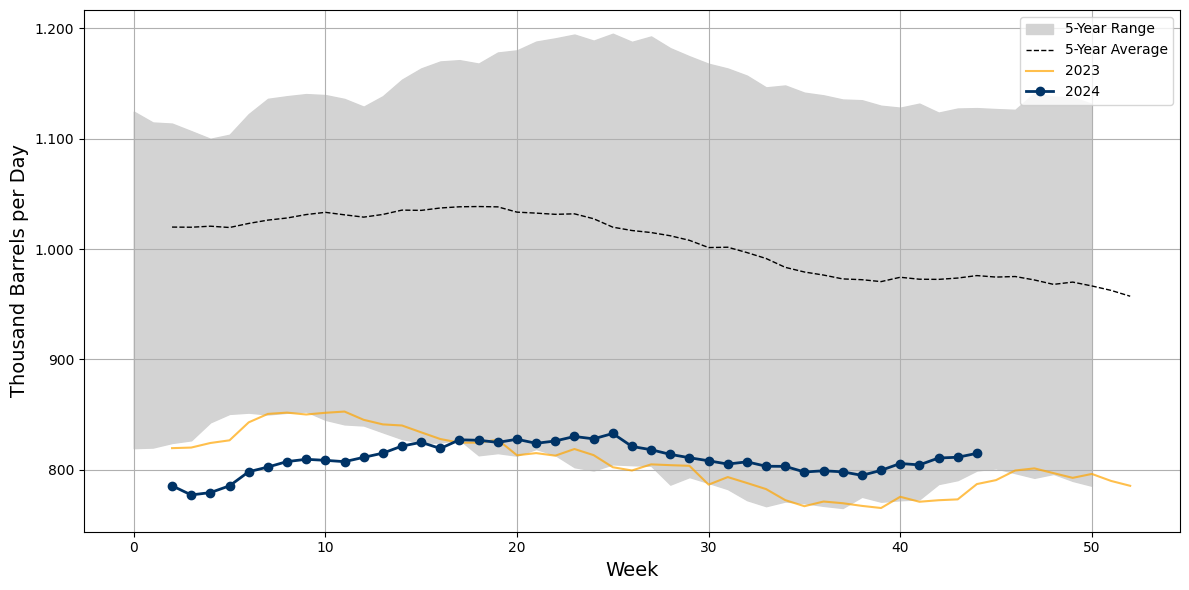

/var/folders/ym/3qhchx8d19q8jp5fvb95q9vw0000gn/T/ipykernel_3112/1278560714.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["5YrMax"] = fiveYearsRange.max(axis=1)
/var/folders/ym/3qhchx8d19q8jp5fvb95q9vw0000gn/T/ipykernel_3112/1278560714.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["5YrMin"] = fiveYearsRange.min(axis=1)
/var/folders/ym/3qhchx8d19q8jp5fvb95q9vw0000gn/T/ipykernel_3112/1278560714.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

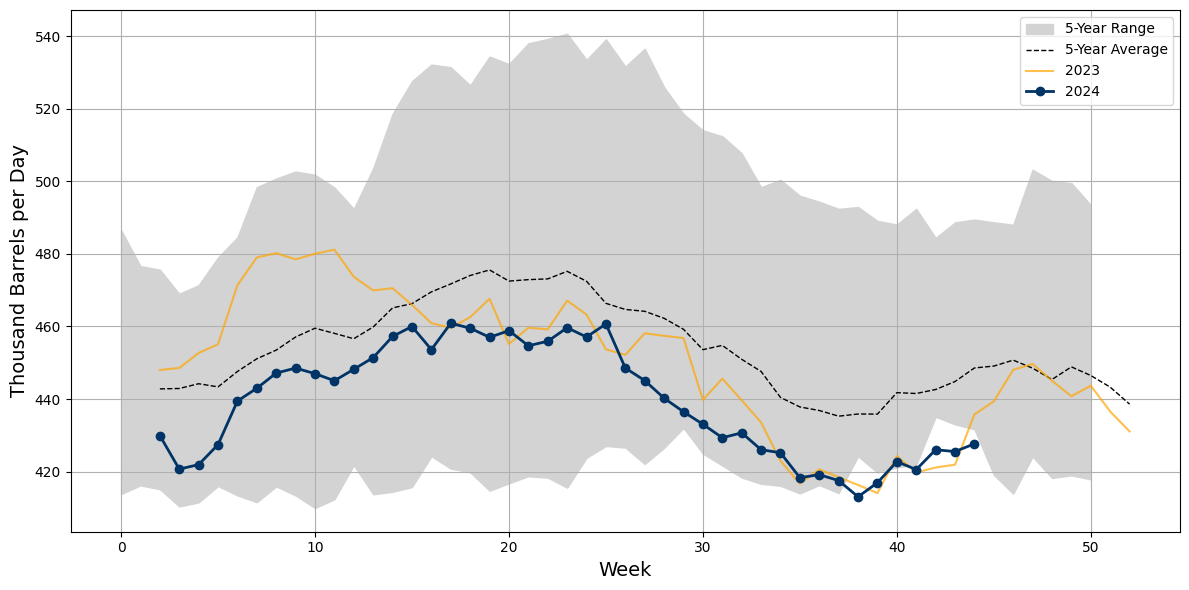

/var/folders/ym/3qhchx8d19q8jp5fvb95q9vw0000gn/T/ipykernel_3112/1278560714.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["5YrMax"] = fiveYearsRange.max(axis=1)
/var/folders/ym/3qhchx8d19q8jp5fvb95q9vw0000gn/T/ipykernel_3112/1278560714.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["5YrMin"] = fiveYearsRange.min(axis=1)
/var/folders/ym/3qhchx8d19q8jp5fvb95q9vw0000gn/T/ipykernel_3112/1278560714.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

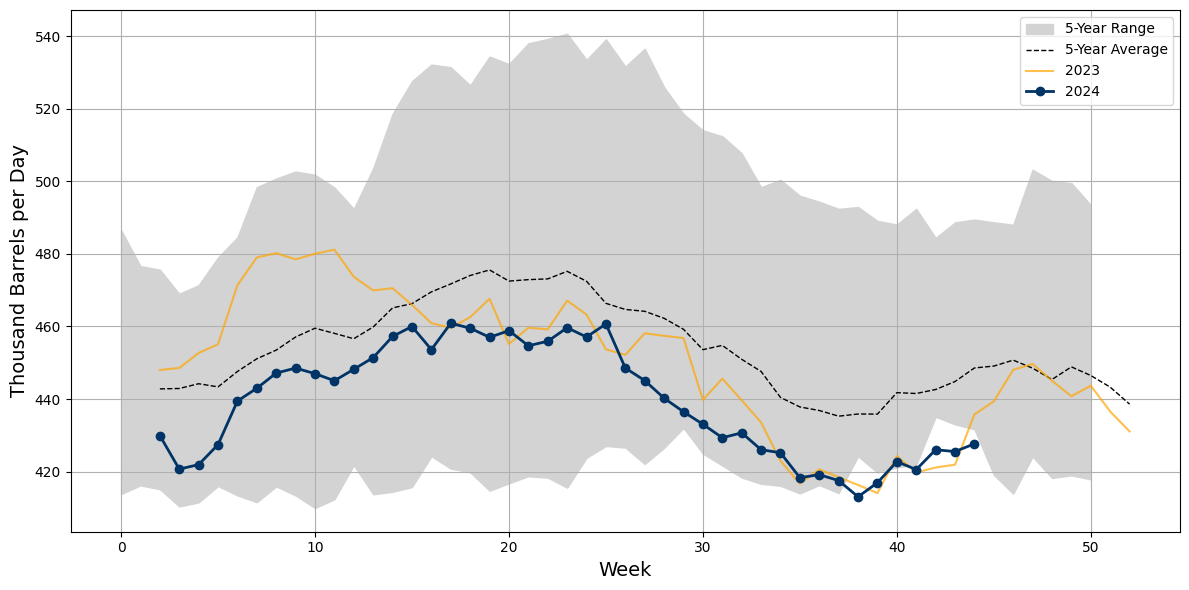

In [7]:
# List all files in the folder
processed_path = "../data/petroleum/processed/"
file_names = os.listdir(processed_path)

# Loop through all files and check for .parquet extension and if the filename contains the number '1'
for file_name in file_names:
    if file_name.endswith('.parquet') and '1' in file_name:
        # Full file path
        file_path = os.path.join(processed_path, file_name)
        
        # Import the Parquet file
        df = pd.read_parquet(file_path)
        
        chart_data = calculate_5_year_metrics(df)
        
        plot_seasonal_trends(chart_data, 'Crude Oil (Including SPR)', source_text="Source: EIA 2024")
        
    if file_name.endswith('.parquet') and '2' in file_name:
        # Full file path
        file_path = os.path.join(processed_path, file_name)
        
        # Import the Parquet file
        df = pd.read_parquet(file_path)
        
        chart_data = calculate_5_year_metrics(df)
        
        plot_seasonal_trends(chart_data, 'Commercial Crude Oil (Excl. Lease Stock)', source_text="Source: EIA 2024")
        
    if file_name.endswith('.parquet') and '2' in file_name:
        # Full file path
        file_path = os.path.join(processed_path, file_name)
        
        # Import the Parquet file
        df = pd.read_parquet(file_path)
        
        chart_data = calculate_5_year_metrics(df)
        
        plot_seasonal_trends(chart_data, 'SPR', source_text="Source: EIA 2024")
        